In [2]:
import numpy as np
import pandas as pd

In [1]:
Outlook = ['sunny','sunny','overcast','rain','rain','rain','overcast','sunny','sunny','rain','sunny','overcast','overcast','rain']
Temperature = [85,80,83,70,68,65,64,72,69,75,75,72,81,71]
Humidity = [85,90,78,96,80,70,65,95,70,80,70,90,75,80]
Windy = [False,True,False,False,False,True,True,False,False,False,True,True,False,True]
Play = ['no','no','yes','yes','yes','no','yes','no','yes','yes','yes','yes','yes','no']

In [4]:
df = pd.DataFrame([Outlook,Temperature,Humidity,Windy,Play]).T
df.columns=['Outlook', 'Temperature', 'Humidity','Windy','Play']

In [5]:
df

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,78,False,yes
3,rain,70,96,False,yes
4,rain,68,80,False,yes
5,rain,65,70,True,no
6,overcast,64,65,True,yes
7,sunny,72,95,False,no
8,sunny,69,70,False,yes
9,rain,75,80,False,yes


In [6]:
def find_entropy(df):
    entropy=0
    Class=df.keys()[-1]
    outcomes=df[Class].unique()
    for outcome in outcomes:
        prob=len(df[Class][df[Class]==outcome])/len(df)
        entropy+= -(prob*np.log2(prob))
    return entropy

In [7]:
find_entropy(df)

0.9402859586706311

In [8]:
def encode_binary(df, attribute):
    optimal_gain = 0
    optimal_val = 0
    vals = list(set(df[attribute]))
    vals.sort()
    vals = vals[:-1]

    for val in vals:
        less_than_equal = df[df[attribute] <= val]
        greater_than = df[df[attribute] > val]

        entropy_less_than_equal = find_entropy(less_than_equal)
        entropy_greater_than = find_entropy(greater_than)

        num = len(df)
        num_less_than_equal = len(less_than_equal)
        num_greater_than = len(greater_than)
        avg_info_entropy = (num_less_than_equal/num)*entropy_less_than_equal + (num_greater_than/num)*entropy_greater_than
        info_gain = entropy - avg_info_entropy

        num_less = num_less_than_equal/num
        num_greater = num_greater_than/num
        split_info = 0
        if num_less != 0:
            split_info -= num_less*np.log2(num_less)
        if num_greater != 0:
            split_info -= num_greater*np.log2(num_greater)

        gain_ratio = info_gain/split_info

        if gain_ratio > optimal_gain:
            optimal_gain = gain_ratio
            optimal_val = val

    df[attribute] = df[attribute] > optimal_val
    df.rename(columns = {attribute : attribute+' > '+str(optimal_val)}, inplace=True)

    return df

In [9]:
entropy=find_entropy(df)

encode_binary(df,'Humidity')
encode_binary(df,'Temperature')

,Outlook,Temperature > 83,Humidity > 65,Windy,Play
0,sunny,True,True,False,no
1,sunny,False,True,True,no
2,overcast,False,True,False,yes
3,rain,False,True,False,yes
4,rain,False,True,False,yes
5,rain,False,True,True,no
6,overcast,False,False,True,yes
7,sunny,False,True,False,no
8,sunny,False,True,False,yes
9,rain,False,True,False,yes


In [10]:
def find_average_information_entropy(df,attribute):
    Class=df.keys()[-1]
    outcomes=df[Class].unique()
    unique_values=df[attribute].unique()
    average_info_entropy=0
    for value in unique_values:
        entropy_subsample=0
        for value1 in outcomes:
            num=len(df[attribute][df[attribute]==value][df[Class]==value1])
            den=len(df[attribute][df[attribute]==value])
            prob=num/den
            entropy_subsample+= -(prob*np.log2(prob+1e-10))
        weight=den/len(df)
        average_info_entropy+= weight*entropy_subsample
    return average_info_entropy

In [11]:
find_average_information_entropy(df,'Outlook')

0.6935361386488728

In [12]:
def calc_split_info(df,attribute):
    den = len(df)
    splitInfo = 0
    unique_vals = df[attribute].unique()

    for value in unique_vals:
        num = len(df[df[attribute]==value])
        prob = num/den
        splitInfo -= prob*np.log2(prob + 1e-10)

    return splitInfo

In [13]:
calc_split_info(df,'Outlook')

1.577406282419537

In [14]:
def find_winner(df):
    GR=[]
    
    for key in df.keys()[:-1]:
        information_gain = find_entropy(df)-find_average_information_entropy(df,key)
        GR.append(information_gain/calc_split_info(df,key))
        
    return df.keys()[:-1][np.argmax(GR)]

In [15]:
find_winner(df)

'Temperature > 83'

In [16]:
def subtable(df,attribute,value):
    return df[df[attribute]==value].reset_index(drop=True)

In [18]:
dictionary={}
for key in df.keys()[:-1]:
        information_gain = find_entropy(df)-find_average_information_entropy(df,key)
        gain_ratio=information_gain/calc_split_info(df,key)
        dictionary[key]=gain_ratio

In [19]:
dictionary

{'Outlook': 0.15642756262088428,
 'Temperature > 83': 0.30547141617109297,
 'Humidity > 65': 0.12851550988292443,
 'Windy': 0.048848615818692244}

In [20]:
import operator
from operator import itemgetter

res = dict(sorted(dictionary.items(), key = itemgetter(1), reverse = True)[:2])
  
print("Using Gain Ratio, the best two attributes that decide the Play attribute are: " + str(res))

Using Gain Ratio, the best two attributes that decide the Play attribute are: {'Temperature > 83': 0.30547141617109297, 'Outlook': 0.15642756262088428}


In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Outlook'] = label_encoder.fit_transform(df['Outlook'])

In [23]:
df

,Outlook,Temperature > 83,Humidity > 65,Windy,Play
0,2,True,True,False,no
1,2,False,True,True,no
2,0,False,True,False,yes
3,1,False,True,False,yes
4,1,False,True,False,yes
5,1,False,True,True,no
6,0,False,False,True,yes
7,2,False,True,False,no
8,2,False,True,False,yes
9,1,False,True,False,yes


In [24]:
X=df.drop('Play',axis=1)
y=df['Play']

In [25]:
chi_scores = chi2(X,y)

In [26]:
chi_scores

(array([2.02814815, 1.8       , 0.04273504, 0.53333333]),
 array([0.15440865, 0.17971249, 0.83622498, 0.46520882]))

In [27]:
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

<AxesSubplot:>

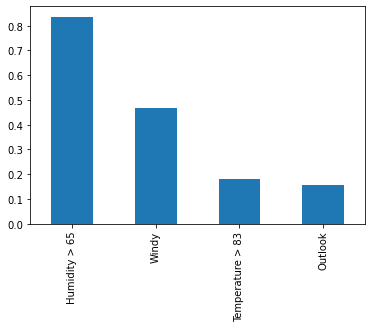

In [28]:
p_values.plot.bar()